# An Introduction to Neural Networks
---
# 03 - Multilayer Perceptron

Vamos esquentar as coisas!
Nesse tutorial, iremos estudar a evolução da Singlelayer Perceptron: a **Multilayer Perceptron** (SLP). Essa é uma das arquiteturas de Rede Neural mais populares até hoje, e é de utilização genérica (pode servir para diversas aplicações).

Diferentemente da SLP, que só funciona bem para problemas que são linearmente separáveis, essa Rede Neural é capaz de realizar classificações mais complexas, mesmo que as _decisions boundaries_ tenham formatos menos "comportados". Essa característica da MLP advém do fato de que a arquitetura dessa rede possui uma camada extra entre a _Camada de Entrada_ e a _Camada de Saída_, denominada _Camada Oculta_, na qual cada neurônio acumula (como seu Potencial de Rede), uma combinação linear das ativações da camada anterior. Como as ativações são não-lineares (devido à Sigmoide), o Potencial de Rede na camada oculta são transformaçoes não-lineares dos atributos de uma observação. Abaixo, uma illustração da Multilayer Perceptron.

<img src="../slides/imgs/mlp_01.png" alt="singlelayer perceptron" width="500px"/>

Neste notebook, iremos modificar algumas da funções auxiliares implementadas pelo Singlelayer Perceptron para incluir a ação da Camada Oculta. Além disso, iremos desenvolver o algoritmo especial de treinamento de Redes Neurais multicamadas: o **Backpropagation**. Após isso, exibiremos o comportamento dessa rede a um comum problema de _Classificação Não-Linear_, que não pode ser resolvido por Redes Neurais simples como o SLP.

### Sumário
* [Parte 1 - Funções Básicas de Redes Neurais Multicamadas](#Parte-1---Funções-Básicas-de-Redes-Neurais-Multicamada)
* [Parte 2 - Treinando a Rede Neural Multicamada](#Parte-2---Treinando-a-Rede-Neural-Multicamada)
* [Parte 3 - Classificação Binária com MLP](#Parte-3---Classificação-Binária-com-MLP)


### Bibliotecas, Variáveis Importantes e Funções Auxiliares

In [1]:
## BIBLIOTECAS ##
import pandas as pd                 # <-- Representação e Manipulação dos Dados
import numpy as np                  # <-- Biblioteca para Operações Matriciais e Complexas
import matplotlib.pyplot as plt     # <-- Biblioteca para Visualização de Dados

## VARIÁVEIS IMPORTANTES ##
colorpad = ["#d11141", "#00aedb", "#00b159", "#f37735", "#ffc425"]
colorpadBG = ["#00aedb50", "#d1114150", "#00b15950", "#f3773550", "#ffc42550"]

## FUNÇÕES AUXILIARES ##
# Plota um fundo colorido para as visualizações
def plotContour(X, model, theta, nClasses=2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model(np.c_[xx.ravel(), yy.ravel()], theta, False)[-1]
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors="#2A2A2A", linewidths=2)
    plt.contourf(xx, yy, Z, levels=range(-1,nClasses), colors=colorpadBG)
    
# Definição da Função Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Definição da Função de Cálculo de Acurácia
def accuracyFunction(X, y, W):
    Y_pred = forward(X, W, False)[-1]
    return 100 * (1 - (1 / np.size(y)) * np.sum((Y_pred - y) ** 2))
    
# Essa linha abaixo é apenas para que os 
# plots sejam gerados na mesma célula do código
%matplotlib inline

### Datasets

Neste tutorial, utilizaremos um dataset artificial, criado apenas para servir como base à explicação dos conceitos relacionados ao treino de Redes Neurais de multicamadas. 

**Obs.:** Note como os dados não podem ser separados por uma linha reta, como era o caso dos dados que utilizamos no tutorial do SLP.  
**Obs.2:** O código abaixo já está pronto. Para mais detalhes sobre como resgatar e manipular dados de arquivos, refira-se ao Tutorial 01.

In [2]:
## CARREGANDO E PRÉ-PROCESSANDO OS DADOS ##
# Carregando os dados a partir do arquivo .csv
data = pd.read_csv("../datasets/data_02.csv")

# Armazenando as dimensões dos dados
m = data.shape[0]
n = data.shape[1]-1

# Transformando as Classes em Números
data["Class"] = data["Class"].astype('category').cat.codes

# Separação do Conjunto de Treino e Conjunto de Teste
np.random.seed(2)
trainingSize = int(0.8 * m)
indexes = np.random.randint(0, m, m)

trainData = data.iloc[indexes[:trainingSize]]
testData = data.iloc[indexes[trainingSize:]]

# Obtendo matrizes (formato Numpy) correspondentes
X_train = trainData.iloc[:,:-1].values
y_train = trainData.iloc[:, -1].values

X_test = testData.iloc[:,:-1].values
y_test = testData.iloc[:, -1].values

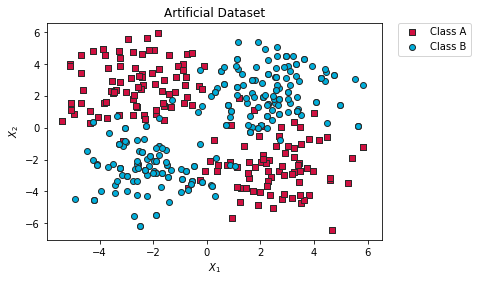

In [3]:
## VISUALIZAÇÃO CONDICIONADA COM O MATPLOTLIB E NUMPY ##
plt.figure()

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

---
## Parte 1 - Funções Básicas de Redes Neurais Multicamada

As Redes Neurais multicamadas possuem camadas intermediárias (chamadas de _Camadas Ocultas_) que são resultados de um processo de ativação dos neurônios das camadas anteriores. Por esse motivo, a Rede Neural é representada por uma **tensor de pesos** (matriz com 3 ou mais dimensões), onde cada elemento é uma matrix representando as transições entre duas camadas, e cada coluna dessas matrizes representam os pesos das sinapses de uma camada para um neurônio. Assim como anteriormente, essa matriz também precisa ser calculada automaticamente pelo processo de aprendizagem.

Para isso, implementaremos as duas principais funções de uma Rede Neural multicamada:

* **Forward Propagation (Propagação Direta):** essa função é responsável por realizar a ativação de cada camada da Rede Neural, desde a Camada de Entrada até a Camada de Saída, e retornar o valor armazenado em cada um desses Neurônios. Perceba que o que é o "passado adiante" aqui são os sinais de entrada (atributos) de uma observação recebida pela Rede, até obtermos a probabilidade da observação pertencer a cada classe.

* **Backpropagation (Propagação Inversa):** esse é o [algoritmo](https://en.wikipedia.org/wiki/Backpropagation#Pseudocode) mais popular para calcular os gradientes dos pesos de uma Rede Neural multicamada. Foi utilizado em Redes Neurais primeiramente em 1986, que foi um evento marcante na história dessa ciência, e até hoje é extremamente popular. Esse algoritmo consiste em calcular, da última até a primeira camada, o erro acumulado em cada Neurônio. Isso é feito ao calcular a diferença entre a classe prevista e a classe real (o erro da Camada de Saída), e então "passar para trás" o valor desse erro ponderado pelos pesos de cada ativação. Esses erros podem ser diretamente utilizados para calcular o gradiente (multiplicando o erro pelo valor do atributo), e então utilizar esses gradientes para treinar a rede utilizando Gradiente Descendente.

**Obs.:** Iremos tratar apenas do caso de Redes com apenas uma Camada Oculta, facilitando as implementações e explicações.

### Forward Propagation
A ativação de cada camada é calculada exatamente como fazíamos no caso do Singlelayer Perceptron. Para calcularmos a ativação de um neurônio em uma cada $l$ utilizamos os neurônios da camada anterior $l-1$, fazemos:

$$
    h^{(l)}(\mathbf{W}^{(l)}) = \varphi(S_\text{net}^{(l)}) = \varphi(W_0^{(l)} + W_1^{(l)} h_1^{(l-1)} + W_2^{(l)} h_2^{(l-1)} + \cdots + W_n^{(l)} h_n^{(l-1)})
$$

Onde $S_\text{net}^{(l)}$ é o **potencial de rede** acumulado na camada anterior em relação ao neurônio que será ativado. Semelhante a anteriormente, podemos calcular facilmente toda a matriz $\mathbf{h}$ utilizando multiplicação matricial, uma vez que cada elemento é resultado de uma soma ponderada. Dessa forma, realizamos a ativação da primeira à ultima camada, sempre lembrando de acrescentar uma coluna de 1's em cada matriz de ativação calculada.

Para o teste abaixo, o restulado deve ser:

> Camada de Entrada:  
>  [ 1  5  4  3  2]  
>  [ 1  1  2  3  4]  
>  [ 1 -2  0  1 -1]  
>
> Camada Oculta:  
>  [  1   5.04347408e-07   1.54465265e-01]  
>  [  1   2.03426978e-04   3.33480731e-03]  
>  [  1   5.52778637e-04   5.74442517e-01]  
>
> Camada de Saída:  
>  [ 0.49441991]  
>  [ 0.67598043]  
>  [ 0.10748569]  


In [4]:
## DEFINIÇÃO DA FUNÇÃO DE FORWARD PROPAGATION ##
def forward(X, W, probs=True):
    # Compensação caso a dimensão das matrizes não batem (ausência da coluna de 1's)
    if(X.shape[1] != W[0].shape[0]): 
        X = np.hstack([np.ones([X.shape[0], 1]), X])
    
    # A primeira matriz de ativação consiste nos próprios atributos recebidos como sinal de entrada
    A = []
    A.append(X)
    
    # Realizamos a ativação de todas as camadas seguintes
    for i in range(0, len(W)):
        Z = sigmoid(np.matmul(A[-1], W[i]))
        if (i < len(W)-1): 
            Z = np.hstack([np.ones([Z.shape[0], 1]), Z])
            
        A.append(Z)
    
    # Caso a opção `probs=False`, então modificamos a última camada para conter apenas valores binários
    if not probs: 
        A[-1] = (A[-1] > 0.5).astype(int)
    
    # Retornamos a ativação de todas as camadas
    return A


In [5]:
## TESTE DA FORWARD PROPAGATION ##
# Observação
X = np.array([[ 5, 4, 3,  2],
              [ 1, 2, 3,  4],
              [-2, 0, 1, -1]])    

# Tensor de Pesos
W = []                            

# 1ª Matriz: C. Entrada -> C. Oculta 
W.append(np.array([[0.5,-0.7],
                   [  1,   2], 
                   [ -3,  -4],
                   [ -4,   3],
                   [  2,  -2]]))  

# 2ª Matriz: C. Oculta -> C. Saída
W.append(np.array([[0.75],
                   [  10],
                   [  -5]]))      

# Cálculo das Ativações
A = forward(X,W)

# Visualização dos Resultados
print("# Resultado das Ativações da Rede Neural #")
print("Camada de Entrada:\n", A[0])
print("\nCamada Oculta:\n", A[1])
print("\nCamada de Saída:\n", A[2])

# Resultado das Ativações da Rede Neural #
Camada de Entrada:
 [[ 1.  5.  4.  3.  2.]
 [ 1.  1.  2.  3.  4.]
 [ 1. -2.  0.  1. -1.]]

Camada Oculta:
 [[  1.00000000e+00   5.04347408e-07   1.54465265e-01]
 [  1.00000000e+00   2.03426978e-04   3.33480731e-03]
 [  1.00000000e+00   5.52778637e-04   5.74442517e-01]]

Camada de Saída:
 [[ 0.49441991]
 [ 0.67598043]
 [ 0.10748569]]


### Backpropagation
A fundamentação teórica que justifica os cálculos do Backpropagation é um pouco complicada, mas o seu algoritmo não é! 

Primeiramente, sabemos que o erro na última camada é diretamente a diferença entre o que foi calculado por ativação na _Forward Propagation_ e o que nós sabemos pela própria matriz de saídas do conjunto de dados. A partir daí podemos "retropropagar" o erro da seguinte forma: o erro em um neurônio da camada $l$ é calculado ao somar cada erro dos neurônios da camada seguinte $l+1$, porém ponderado pelos pesos das sinapses que ligam esses neurônios. Além disso, também multiplicamos o erro pela derivada da ativação deste neurônio, para sabermos a direção que o erro estava mudando.

Dessa forma, a fórmula do erro de um neurônio $i$, calculado por Backpropagation, é

$$
    e_i^{(l)} = \left( e_1^{(l+1)} W_1^{(l)} + e_2^{(l+1)} W_2^{(l)} + \cdots + e_n^{(l+1)} W_n^{(l)} \right) \cfrac{d \varphi(S_{i_\text{net}}^{(l)})}{dW}
$$

Onde a derivada da ativação é calculada como:

$$
    \cfrac{d \varphi(S_{i_\text{net}}^{(l)})}{dW} = h_i^{(l)}(1-h_i^{(l)})
$$

Note, novamente, que as operações não passam de somas ponderadas. Por esse motivo, podemos facilmente calcular todos os erros usando multiplicação matricial.

Para o teste abaixo, o restulado deve ser:

> Erro na Camada Oculta:  
> [ -2.54987879e-06,   3.30158326e-01]  
> [ -6.59009122e-04,   5.38469706e-03]  
> [  5.93829509e-04,   -1.31378855e-01]  

> Erro na Camada de Saída:  
> [-0.50558009]  
> [-0.32401957]  
> [ 0.10748569]  

In [6]:
## DEFINIÇÃO DA FUNÇÃO DE BACKPROPAGATION ##
def backprop(A, y, W):
    # A primeira matriz de erros é calculada diretamente da diferença entre a classe real e a prevista
    E = []
    E.append(A[-1] - y)
    
    # O erro é, então, propagado para trás até termos os erros da primeira Camada oculta
    for i in range(len(W)-1, 0, -1):
        E.append(np.matmul(E[-1], W[i].T) * A[i] * (1-A[i]))
        E[-1] = E[-1][:,1:]
        
    # Retornamos o erro calculado em todas as camadas, na ordem inversa do cálculo
    return E[::-1]
 

In [7]:
## TESTE DA BACKPROPAGATION ##
# Observação
X = np.array([[ 5, 4, 3,  2],
              [ 1, 2, 3,  4],
              [-2, 0, 1, -1]])    
y = np.array([[1],
              [1],
              [0]])

# Tensor de Pesos
W = []                            

# 1ª Matriz: C. Entrada -> C. Oculta 
W.append(np.array([[0.5,-0.7],
                   [  1,   2], 
                   [ -3,  -4],
                   [ -4,   3],
                   [  2,  -2]]))  

# 2ª Matriz: C. Oculta -> C. Saída
W.append(np.array([[0.75],
                   [  10],
                   [  -5]]))      

# Cálculo da Ativação e dos Erros da Rede Neural
A = forward(X,W)
E = backprop(A,y,W)

# Visualização dos Resultados
print("# Resultado dos Erros da Rede Neural #")
print("Erro na Camada Oculta:\n", E[0])
print("\nErro na Camada de Saída:\n", E[1])

# Resultado dos Erros da Rede Neural #
Erro na Camada Oculta:
 [[ -2.54987879e-06   3.30158326e-01]
 [ -6.59009122e-04   5.38469706e-03]
 [  5.93829509e-04  -1.31378855e-01]]

Erro na Camada de Saída:
 [[-0.50558009]
 [-0.32401957]
 [ 0.10748569]]


---
## Parte 2 - Treinando a Rede Neural Multicamada
O Treino de uma Rede Neural multicamada é um processo de otimização exatamente igual ao que realizamos no caso do _Singlelayer Perceptron_.

Nesse caso, temos apenas que nos lembrar de que existem duas camadas de pesos que devem ser atualizadas. Todavia, cada uma delas pode ser atualizada individualmente assim como fizemos anteriormente: utilizando o **Gradiente Descendente**. Nesse caso, lembre-se que todas as ativações, assim como os erros, são calculados através de uma função. Essas são as informações que utilizamos para atualizar os pesos. _Abaixo, reescrevemos o algoritmo do Gradiente Descendente com mudança em algumas notações para facilitar o entendimento da implementação_:

### Gradiente Descendente

Seja uma Rede Neural multicamada com $L$ camadas, onde $A^{(l)}$ é a matriz de ativação em cada camada $l$ e $E^{(l)}$ é a matriz de ativação em cada camada $l$. Nesse caso, $A^{(L)}$ representa o valor de ativação da _Camada de Saída_ e $E^{(L)}$ representa a diferença dessa ativação para os valores reais de $\mathbf{y}$. O algoritmo do Gradiente Descendente pode ser implementado como:

1. Calculamos todas as ativações, $A^{(l)} = h(\mathbf{W}^{(i)})$, de todos os exemplos utilizando os pesos $\mathbf{W}^{(i)}$ para essa $i$-ésima época;  

2. Utilizamos as ativaçoes, $A^{(l)}$, e os valores reais, $\mathbf{y}$, para calcular a acurácia total do modelo (utilizando a função _accuracyFunction_) e o _Erro Quadrático Médio_ (MSE), representado pela fórmula:

    $$ 
        J(\mathbf{w}^{(i)}) = MSE^{(i)} = \cfrac{1}{m} \sum_{i=0}^n (A^{(L)} - \mathbf{y})^2 
    $$
   
   e adicionamos o resultado em um _histórico de erros_.  
   **Obs.:** O MSE é a nossa função de Custo Total, comumente representada como $J(\mathbf{W}^{(i)})$  <br>
   
3. Realizamos o passo do gradiente para cada camada, atualizando os pesos $\mathbf{W}^{(i)}$ de uma camada de acordo com a regra:

    $$ 
        \mathbf{W}^{(i+1)} = \mathbf{W}^{(i+1)} - \alpha \nabla J(\mathbf{W}^{(i)})
    $$
    
    onde $\alpha$ é um ajuste de escala arbitrário (geralmente um valor menor que 1) denominado _Taxa de Aprendizagem_ e $\nabla J(\mathbf{W}^{(i)})$ representa o vetor gradiente da função de Custo Total, que pode ser calculado matricialmente como:
    
    $$ 
        \nabla J(\mathbf{W}^{(i)}) = (A^{(l)})^T E^{(l)}
    $$  <br>
    
4. Imprimimos o resultado do treinamento (valores dos pesos, acurácia, erros calculados, etc.) a cada 50 épocas;  <br>

5. Checamos se a diferença do erro anterior para o erro atual é menor que a tolerância indicada (indicando possível convergência). Se for verificada a convergência, interrompemos o laço das iterações; <br>

6. Caso não houve convergência, atualizamos as variáveis auxiliares e retornamos ao Passo 1. <br>

In [8]:
###############################
#    Treinamento do MLP    #
###############################
def mlp_train(X, y, n_hidden, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=False):
    # Armazena as dimensões dos dados (m -> exemplos, n -> atributos)
    m = X.shape[0]; n = X.shape[1]
    
    # Define o Histórico de Erros e algumas variáveis auxiliares
    errorHist = []
    previousMSE = 0
    it = 1;
    
    # Cria um atributo extra para todos os exemplos iguais a x_0 = 1
    X = np.hstack([np.ones([m,1]), X])
    y = y.reshape(-1,1)
    
    # Cria o vetor de pesos da Rede Neural (inicialização aleatória)
    W = [np.random.randn(n+1, n_hidden), np.random.randn(n_hidden+1, 1)]
    
    # Realiza o treino por Gradiente Descendente
    while(it <= maxIt):
        # 1. Calculamos a ativação de todos os neurônios (Forward Propagation) e 
        #    retropropagamos o erro da predição (Backpropagation)
        A = forward(X, W)
        E = backprop(A, y, W)
        
        # 2. Calculamos o erro MSE, a acurácia do modelo e adicionamos o resultado no histórico.
        actualMSE = (1/m) * np.sum(E[1]**2)
        actualAcc = accuracyFunction(X, y, W)
        errorHist.append(actualMSE)
        
        # 3. Realizamos o passo do Gradiente Descendente.        
        for i in range(0, 2):
            W[i] = W[i] - (alpha/m) * np.matmul(A[i].T, E[i])
        
        # 4. Imprimimos o resultado do treinamento a cada 50 épocas.
        if(it % 50 == 0 and verbose): 
            print("## Iteration", it, "##")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.3f}%".format(actualAcc))
            print("Weights\nS -> H:\n", W[0], "\nH -> O:\n", W[1])
            print("\n")
        
        # 5. Verificamos uma possivel convergência do treinamento, e então encerramos o laço.
        if(abs(actualMSE - previousMSE) <= tol):
            print("## Iteration", it, "##")
            print("!!! Convergence reached !!!")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.3f}%".format(actualAcc))
            print("Weights\nS -> H:\n", W[0], "\nH -> O:\n", W[1])
            print("\n")
            break;
            
        # 6. Atualizamos as variáveis auxiliares para as próximas iterações.
        previousMSE = actualMSE
        it +=1
    
    # Fim do Treinamento
    return (W, errorHist)

---
## Parte 3 - Classificação Binária com MLP

Agora que possuímos todas as ferramentas devidamente implementadas, podemos utilizar nossa Rede Neural para aprender padrões não-lineares em conjuntos de dados destinados a _Classificação_. Nesse notebook, utilizaremos um conjunto de dados artificial gerado para que possamos visualizar como se comporta essa Rede Neural.

Os dados já estão carregados como as variáveis **X_train** e **y_train**. Execute os blocos abaixo para visualizar a Rede Neural em ação. 

### Execução do Treinamento

Primeiramente, executamos o método de treinamento para obtermos o conjunto ótimo de pesos para cada sinapse. É **recomendável** que o aluno "brinque" um pouco com os parâmetros do método para entender melhor como os parâmetros influenciam no treinamento. No caso de Redes Neurais multicamadas, o número de neurônios na Camada Oculta muda completamente a complexidade dos modelos que a Rede pode aprender; tente modificar esse parâmetro e notar as diferenças!

**Obs.:** O resultado do treinamento também depende da inicialização dos pesos das sinapses, que é aleatória, e por isso talvez seja necessário re-executar o treinamento caso os resultados não sejam bons. (Essa é uma desvantagem do Gradiente Descendente).

**Obs.2:** O método deve convergir. Caso contrário, reveja a implementação do Gradiente Descendente!

In [9]:
## EXECUÇÃO DO TREINAMENTO ##
[W, errorHist] = mlp_train(X=X_train, y=y_train, n_hidden=20, alpha=0.1, verbose=False)

## Iteration 1361 ##
!!! Convergence reached !!!
MSE: 	 0.0553777651688
Accuracy: 93.542%
Weights
S -> H:
 [[-0.66445667 -2.07423192  1.21450639  2.49231394 -2.57973088 -1.06008605
   0.54678648 -0.74574545 -1.55102097 -0.64156195 -2.1085684  -1.46255071
  -1.44123459 -1.03545861 -0.16651493  1.82594697 -0.19461209 -1.89631248
  -1.01840864  0.95946454]
 [ 0.68645994  1.11375986 -0.66482099 -1.11031527 -1.26761991  0.57722093
  -1.0502422   0.51390465 -0.67407004 -1.04175151  0.93409667  0.68104821
  -0.99366836 -0.6809897  -0.43855813  0.72762087 -0.72815059 -0.73654958
  -1.472821   -0.56251013]
 [-1.47142864 -0.74202702 -0.68744787  1.40702849 -1.00947729  0.7660965
   0.72854534 -0.82707796  0.68700813  1.38036044 -0.7381143   0.60741508
  -1.01602726  2.17837902 -2.0482583  -0.67382499  1.74048699  0.68364623
   0.62567801 -1.60694624]] 
H -> O:
 [[-0.05745444]
 [ 0.24933742]
 [ 2.53720703]
 [ 0.87450861]
 [-2.50985089]
 [-3.36521107]
 [-1.04273013]
 [-0.66682351]
 [ 1.05778678]
 

### Histórico de Erro do Treinamento

O Gradiente Descendente também possui uma característica bem legal de que a função de custo que estamos utilizando, o MSE, sempre decresce a cada iteração do treinamento, em busca do valor mínimo. Se plotarmos o histórico de erro, podemos visualizar como o treinamento se comportou durante os passos dsse método.

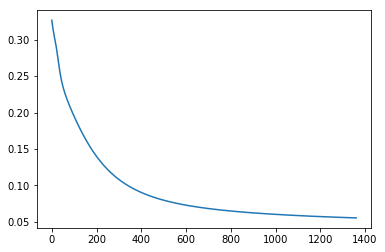

In [10]:
## VISUALIZAÇÃO DO HISTÓRICO DE ERROS ##
plt.figure()
plt.plot(errorHist)
plt.show()

### Visualização da Classificação

Agora que temos o conjunto de pesos devidamente treinados, podemos construir uma visualização para exibir como a Rede Neural está classificando os dados em todo o espaço. A função _plotContour_, que já está implementada, recebe um conjunto de pesos já treinados e classifica todos os pontos no plano de visualização. A classe atribuída a cada área corresponde à cor exibida no fundo do plano. A linha preta que divide as áreas é denominada de **Decision Boundary**, e é interpretada como a região do espaço dos exemplos em que podemos notar a divisão das classes.

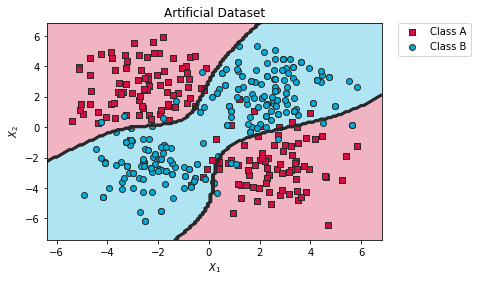

In [11]:
## VISUALIZAÇÃO DA CLASSIFICAÇÃO ##
plt.figure()

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plotContour(X_train, forward, W)

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
